# scRNAseq downstream analysis

Based on Jupyter Notebook created by Lauren Sanders.


### Downstream analysis - chunk by chunk:
* Each codeblock is a separate script - I loaded libraries before function, because I copy the whole code to python scripts.
* To run whole analysis, simply run main.py

#### Module0: Parameters.py

In [1]:
#Input paths:
base_path = r"C:\Users\kkomenda\Documents\scRNAseq\test"

#marker file is necessary to load link for table:
marker_file = 'https://raw.githubusercontent.com/nasa/GeneLab_Data_Processing/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Info.csv'

In [2]:
"""
This script stores all necessary default parameters: 
"""
#Study metadata:
Species = "Mus musculus"
Tissue= "bone marrow"
#Basic Filtering parameters:
DEFAULT_GENES_PERCENTILE = 1

DEFAULT_CELLS_PERCENTILE = 5

#Parameters to plot Genes and Cells:
save_format = "png"
save_dpi = 300
genes_plot = True
cells_plot = True

#Parameters for Violin plots etc:
jitter_param = 0.4

#filter cells based on gene counts (basic is 2500):
filter_gene_counts = 2500

#number of pcs in PCA plot:
n_pcs=20

#Module8 - filterCells:
filterCell_threshold = 5

#resolution of leiden clustering:
cluster_resolution= 0.5 # by default: 0.5 means coarser clusters, 1.0 - finer clusters

#scoreCT parameters annotation:
null_model_param='multinomial'
cluster_key_param='leiden'
clustering_method="wilcoxon"

#plotUMAP:
umap_color= "scoreCT"

#### Module1: Structure.py
- Generate folder structure: plots and AnnData results

In [3]:
import os

def Structure():
    """
    Generate folder structure: plots and AnnData results
    """
    # Define folder names
    folders = ['plots', 'AnnData']
    
    # Create the folders if they don't exist
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)
            print(f"Folder '{folder}' created.")
        else:
            print(f"Folder '{folder}' already exists.")

#### Module1.5: GetDirectories.py

In [4]:
import os
import gzip
import shutil

#load base directory path:
out = []

def GetDirectories(base_path=None):
    """
    Function for getting directories, checking if they are zipped properly and storing them in 
    out variable.

    NOTE: It does not matter the structure of folders, it looks for "filtered" folder only!
    """
    global out
    
    required_files = {"barcodes.tsv.gz", "features.tsv.gz", "matrix.mtx.gz"}
    out = []  # Clear the global variable before running

    for root, dirs, files in os.walk(base_path):
        # Skip hidden directories
        dirs[:] = [d for d in dirs if not d.startswith('.')]

        # Check if the current path contains "filtered"
        if "filtered" in root.split(os.sep):
            out.append(root)

            # Check for existing .gz files
            existing_files = {f for f in files if f.endswith(".gz")}
            missing_files = required_files - existing_files  # Find missing required files

            # Zip missing files
            for missing in missing_files:
                original_file = missing.replace(".gz", "")
                original_path = os.path.join(root, original_file)

                if os.path.exists(original_path):  # Ensure the original file exists
                    with open(original_path, 'rb') as f_in:
                        with gzip.open(original_path + '.gz', 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    print(f"Zipped: {original_path} -> {original_path}.gz")
                else:
                    print(f"Missing file for zipping: {original_path}")

            # If all required files are present
            if not missing_files:
                print(f"All required .gz files are already present in: {root}")

    print("Filtered directories:", out)

#### Module2: GitLoad.py

In [5]:
import pandas as pd

GeneMarkers = None

def GitLoad(csv_url):

    #set GeneMarkers globally - it is a path to formatted file
    global GeneMarkers
    
    # Load GitHub link
    df = pd.read_csv(csv_url)
    df = pd.DataFrame(df)
    
    # Filter DataFrame based on predefined Species and Tissues
    filtered_df = df[(df['Species'] == Species) & (df['Tissue'] == Tissue)]

    
    if not filtered_df.empty:
        link = filtered_df['Link'].values[0] #Catch link for matched filter
        name = filtered_df['Gene Marker File'].values[0] #Catch name for file
        name = name.replace(".csv", "") #clean filename
        GeneMarkers = name + ".gmt" #prepare file output name
        
    else:
        print("No matching rows found")
        return

    #Converting procedure from csv to gmt if it will not find proper gmt file:
    if not link.endswith(".gmt"):

        df_link = pd.read_csv(link)
        #set up names:
        column_name = 'cellName'
        column_gene = 'geneSymbol'

        #security:
        if column_name not in df_link.columns or column_gene not in df_link.columns:
            GeneMarkers = None
            return

        #split and select only columns that are needed:
        df_selected = df_link[[column_name, column_gene]]
        df_split = df_selected[column_gene].str.split(',', expand=True)
        df_result = pd.concat([df_selected[[column_name]], df_split], axis=1)
       
        #Add another column to avoid issues in reading gmt file
        df_result.insert(1, 'na_column', 'na')
        
        #save file:
        df_result.to_csv(GeneMarkers, sep='\t', header=False, index=False)

#### Module3: SaveData.py

In [6]:
import matplotlib.pyplot as plt  # Ensure this is imported
import os
def SaveData(adata=None, genes_plot=None, cells_plot=None, mt_analysis=False, 
             genes_counts=None, total_counts=None, pct_counts_mt=None, 
             pct_mt_scatter=None, genes_counts_scatter=None, postNormplot = None, PCAplot=None, scoreCT_out=None, umap=None, ClusterPlot=None, count_matrix=None, metadata=None):
    """
    Function executes data saving from user defined preferences.
    By default, all parameters are empty and saving is not executed.

    By default, saving plot format is set to png and dpi is set to 300.
    It is possible to change parameters in parameters.py function.
    """
    # Create folders if they do not exist
    if not os.path.exists('AnnData'):
        os.makedirs('AnnData')
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
        
    if adata is not None:
        adata.write(f"AnnData/{sample_name}_filtered.h5ad")
        print(f"Filtered data saved to {sample_name}_filtered.h5ad")
    
    if genes_plot is not None:
        genes_plot.figure.savefig(f"plots/{sample_name}_genes_plot.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved genes_plot plot as {sample_name}_genes_plot.{save_format}")

    if cells_plot is not None:
        cells_plot.figure.savefig(f"plots/{sample_name}_cells_plot.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved cells_plot plot as {sample_name}_cells_plot.{save_format}")
        
    if genes_counts is not None:
        genes_counts.figure.savefig(f"plots/{sample_name}_violin_genes_counts.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved genes_counts plot as {sample_name}_violin_genes_counts.{save_format}")

    if total_counts is not None:
        total_counts.figure.savefig(f"plots/{sample_name}_violin_total_counts.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved total_counts plot as {sample_name}_violin_total_counts.{save_format}")

    if pct_counts_mt is not None:
        pct_counts_mt.figure.savefig(f"plots/{sample_name}_violin_pct_counts_mt.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved pct_counts_mt plot as {sample_name}_violin_pct_counts_mt.{save_format}")

    if pct_mt_scatter is not None:
        pct_mt_scatter.figure.savefig(f"plots/{sample_name}_scatter_pct_mt.{save_format}",  bbox_inches='tight' ,dpi=save_dpi)
        print(f"Saved pct_mt_scatter plot as {sample_name}_scatter_pct_mt.{save_format}")

    if genes_counts_scatter is not None:
        genes_counts_scatter.figure.savefig(f"plots/{sample_name}_scatter_genes_counts.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved genes_counts_scatter plot as {sample_name}_scatter_genes_counts.{save_format}")

    if postNormplot is not None:
        postNormplot.figure.savefig(f"plots/{sample_name}_HighlyExpressedGenes.{save_format}",  bbox_inches='tight' ,dpi=save_dpi)
        print(f"Saved HighlyExpressedGenes plot as {sample_name}_HighlyExpressedGenes.{save_format}")

    if PCAplot is not None:
        PCAplot.figure.savefig(f"plots/{sample_name}_PCAplot.{save_format}", bbox_inches='tight' , dpi=save_dpi)
        print(f"Saved PCAplot plot as {sample_name}_PCAplot.{save_format}")

    if scoreCT_out is not None:
        scoreCT_out.write(f"AnnData/{sample_name}_annotated.h5ad")
        print(f"Annotated data saved to {sample_name}_annotated.h5ad")

    if umap is not None:
        umap.figure.savefig(f"plots/{sample_name}_UMAP_{umap_color}.{save_format}", bbox_inches='tight', dpi=save_dpi)
        print(f"Saved UMAP plot as {sample_name}_UMAP_{umap_color}.{save_format}")

    if ClusterPlot is not None:
        ClusterPlot.savefig(f"plots/{sample_name}_ClusterPlot.{save_format}", bbox_inches='tight' ,  dpi=save_dpi)
        print(f"Saved ClusterPlot plot as {sample_name}_ClusterPlot.{save_format}")

    if count_matrix is not None:
        count_matrix.to_csv(f"count_matrix_{sample_name}.csv")
        print(f"Raw count matrix was saved to: count_matrix_{sample_name}.csv")

    if metadata is not None:
        metadata.to_csv(f"metadata_{sample_name}.csv")
        print(f"Metadata was saved to: metadata_{sample_name}.csv")


#### Module4: BasicFiltering.py

In [7]:
import numpy as np
import scanpy as sc

def BasicFiltering(Organism=Species, genes_percentile=None, cells_percentile=None, save_data=False):

    #Adding parameter organism and different parameters for the future:
    
    if Organism == "Drosophila melanogaster":
        
        # Set specific values for Drosophila
        genes_percentile = 5
        cells_percentile = 5
        
    elif Organism == "Zebrafish":
        
        # Set specific values for Zebrafish
        genes_percentile = 3
        cells_percentile = 5
        
    elif Organism == "Arabidopsis thaliana":
        
        # Set specific values for Arabidopsis thaliana
        genes_percentile = 1
        cells_percentile = 5

    # Calculate QC metrics
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cdf = stat[0]
    gdf = stat[1]

    # Use user-specified percentiles or defaults
    genes_percentile = genes_percentile if genes_percentile is not None else DEFAULT_GENES_PERCENTILE
    cells_percentile = cells_percentile if cells_percentile is not None else DEFAULT_CELLS_PERCENTILE

    # Calculate thresholds
    genes = list(set(cdf['n_genes_by_counts']))
    cells = list(set(gdf['n_cells_by_counts']))

    gene_threshold = np.percentile(genes, genes_percentile)
    cell_threshold = np.percentile(cells, cells_percentile)


    # Save the thresholds in adata.uns
    adata.uns['gene_threshold'] = gene_threshold
    adata.uns['cell_threshold'] = cell_threshold

    #Perform filtering 
    sc.pp.filter_cells(adata, min_genes=gene_threshold)
    sc.pp.filter_genes(adata, min_cells=cell_threshold)

    print(f'Filter out cells expressing fewer than: {gene_threshold} genes ({genes_percentile}th percentile)')
    print(f'Filter out genes detected in fewer than: {cell_threshold} cells ({cells_percentile}th percentile)')

    # Save adata if requested
    if save_data:
        SaveData(adata=adata)
    return adata
    

#### Module5: plotCellsAndGenes.py
Plot 1 and 2: Distribution plot of genes vs cells and cells vs genes:

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

def plotCellsAndGenes(genes_plot=genes_plot, cells_plot=cells_plot, save_data=False):
  
    # Calculate QC metrics based on the filtered adata from BasicFiltering
    stat = sc.pp.calculate_qc_metrics(adata, inplace=False)
    cell_qc_dataframe = stat[0]
    gene_qc_dataframe = stat[1]

    # Retrieve the filtering thresholds from the adata object after BasicFiltering
    gene_threshold = adata.uns.get('gene_threshold', None)
    cell_threshold = adata.uns.get('cell_threshold', None)
    
    if gene_threshold is None or cell_threshold is None:
        raise ValueError("Filtering thresholds not found in the adata object. Ensure BasicFiltering was run.")

    print(f'Gene threshold: {gene_threshold}')
    print(f'Cell threshold: {cell_threshold}')

    # Unique variables for plot data
    genes_plot_data = None
    cells_plot_data = None

    # Plot Number of Genes by Counts (only if genes_plot is True)
    if genes_plot:
        fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for genes plot
        ax.hist(cell_qc_dataframe['n_genes_by_counts'], bins="sqrt")
        ax.set(xlabel='N genes', ylabel='N cells')
        ax.axvline(gene_threshold, color='red')
        ax.set_title("Number of genes by counts")
        #plt.show()
        genes_plot_data = fig  # Store figure for later use

    # Plot Number of Cells by Counts (only if cells_plot is True)
    if cells_plot:
        fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure for cells plot
        ax.hist([int(x) for x in gene_qc_dataframe['n_cells_by_counts'] if x != 0], bins="sqrt")
        ax.set(xlabel='N cells expressing > 0', ylabel='N genes')
        ax.axvline(cell_threshold, color='red')
        ax.set_title("Number of cells by counts")
        #plt.show()
        cells_plot_data = fig  # Store figure for later use
    
    if save_data:
        SaveData(genes_plot=genes_plot_data, cells_plot=cells_plot_data)
        print(f"Genes plot and Cells plot were saved!")
    

#### Module6: mtAnalysis.py
* Annotate mitochondrial genes (optional)

In [9]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mtAnalysis(analysis=True, save_mt=False):

    if analysis:
        # Check for common mitochondrial gene prefixes in the first 50 gene names
        mitochondrial_prefixes = ["MT-", "mt-", "M-", "m-", "mito-", "MITO-"]
        for prefix in mitochondrial_prefixes:
            mt_genes = [gene for gene in adata.var_names if gene.startswith(prefix)]
            if mt_genes:
                print(f'Prefix "{prefix}" found with {len(mt_genes)} mitochondrial genes:')
                print(mt_genes[:10])  # Print the first 10 mitochondrial genes found
                # Annotate mitochondrial genes as "mt"
                adata.var["mt"] = adata.var_names.str.startswith(prefix)
                break
            # Add flag to indicate mitochondrial analysis was performed
            adata.uns['mt_analysis'] = True
        
        else:
            print("No common mitochondrial gene prefix found in the first 50 gene names.")
            adata.var["mt"] = False  # No mitochondrial genes found

        # Calculate QC metrics including mitochondrial genes
        sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
        print(f"Annotated mitochondrial genes and calculated QC metrics.")
    else:
        # Perform QC metrics calculation without mitochondrial gene annotation
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        print(f"Calculated QC metrics.")

    # Freeze current state for saving
    adata_frozen = adata.copy()

    # Save data if requested
    if save_mt:
        SaveData(adata=adata_frozen, mt_analysis=True)

    return adata

#### Module7: plotViolinScatter.py
- title does not work

In [10]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotViolinScatter(genes_counts=True, total_counts=True, pct_counts_mt=True, pct_mt_scatter=True, genes_counts_scatter=True, save_data=False):

    plots_data = {}

    # Collect generated plots for saving
    genes_counts_fig = None
    total_counts_fig = None
    pct_counts_mt_fig = None
    pct_mt_scatter_fig = None
    genes_counts_scatter_fig = None
    
    # Violin plots
    if genes_counts:
        genes_counts_fig = sc.pl.violin(adata, "n_genes_by_counts", jitter=jitter_param, show=False)

    
    if total_counts:
        total_counts_fig = sc.pl.violin(adata, "total_counts", jitter=jitter_param, show=False)
       
    if pct_counts_mt:
        if "pct_counts_mt" in adata.obs:
            pct_counts_mt_fig = sc.pl.violin(adata, "pct_counts_mt", jitter=jitter_param, show=False)
           
    # Scatter plots
    if pct_mt_scatter:
        pct_mt_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False)
       
    if genes_counts_scatter:
        genes_counts_scatter_fig = sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False)
        
    # Save data if requested
    if save_data:
       SaveData(
           genes_counts=genes_counts_fig,
           total_counts=total_counts_fig,
           pct_counts_mt=pct_counts_mt_fig,
           pct_mt_scatter=pct_mt_scatter_fig,
           genes_counts_scatter=genes_counts_scatter_fig
       )

#### Module8: FilterCells.py

In [11]:
import scanpy as sc

def FilterCells():
    global adata

    # Check if 'mt_analysis' exists in adata.uns and is True
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Filter cells based on gene counts and mitochondrial content
        adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
        adata = adata[adata.obs.pct_counts_mt < filterCell_threshold, :].copy()  # Assuming you want to filter out cells with more than 5% mitochondrial genes
        print(f"Filtered cells based on gene counts with mt_analysis.")
    else:
        # Filter cells based only on gene counts
        adata = adata[adata.obs.n_genes_by_counts < filter_gene_counts, :]
        print(f"Filtered cells based on gene counts.")

#### Module9: Normalization.py & RegressOut.py

In [35]:
import numpy as np
import scanpy as sc

def Normalization(adata):
    """
    Normalize and preprocess the AnnData object.

    Returns:
    - Processed AnnData object.
    """
        # Freeze state:
    adata.raw = adata.copy()
    
    # Correct for library size:
    sc.pp.normalize_total(adata, target_sum=1e4)

    # Perform log transformation:
    sc.pp.log1p(adata)

    # Identify highly variable genes:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


    
    return adata

In [13]:
import numpy as np
import scanpy as sc

def RegressOut(adata):
    
    # Subset the data to include only highly variable genes:
    adata = adata[:, adata.var.highly_variable]

    # Check if mitochondrial analysis has been performed by checking adata.uns['mt_analysis']
    if 'mt_analysis' in adata.uns and adata.uns['mt_analysis'] == True:
        # Regress out total counts and mitochondrial gene percentages
        sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    else:
        # Only regress out total counts if mitochondrial analysis wasn't run
        sc.pp.regress_out(adata, "total_counts")

    # Scale the data
    sc.pp.scale(adata, max_value=10)
    
    return adata

#### Module10: plotPostNormalization.py

In [14]:
import scanpy as sc
import matplotlib.pyplot as plt

def plotPostNormalization(save_data=False):
    
    global adata
    
    ax = sc.pl.highest_expr_genes(adata, n_top=20, show=False)
    
    # Set the title of the plot
    plt.suptitle(f"20 most highly expressed genes in sample: {sample_name}", fontsize=16)
    
    # If `save_data` is True, save the plot via SaveData function
    if save_data:
        postNormplot = ax.figure  # Store the plot figure
        SaveData(postNormplot=postNormplot)
    
    # Display the plot
    #plt.show()

#### Module11: plotPCA.py

In [15]:
import matplotlib.pyplot as plt
import scanpy as sc

def plotPCA(save_data=False):
    
    global adata

    #Calculate PCA:
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pl.pca_variance_ratio(adata, log=True, n_pcs = n_pcs, show=False)

    #title is not working...
    fig = plt.gcf()

    plt.suptitle(f"PCA Variance Ratio (Top {n_pcs} PCs in sample: {sample_name})", fontsize=16)
    fig.subplots_adjust(top=0.9)

    if save_data:
        plt.draw()
        SaveData(PCAplot=fig)
    
    
    #plt.show()

#### Module12: ClusterAnalysis.py

In [36]:
import scanpy as sc
import pandas as pd

def ClusterAnalysis():

    global adata
    #compute neighbor graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
    
    #Embed graph into 2 dimensions using UMAP:
    sc.tl.umap(adata)
    
    #perfom leiden clustering:
    sc.tl.leiden(adata, resolution= cluster_resolution)
    
    #compute ranking for highly expressed genes:
    sc.tl.rank_genes_groups(adata, cluster_key_param, use_raw=False ,method=clustering_method)
    
    return adata

#### Module 12.5: ClusterPlot.py

In [17]:
import matplotlib.pyplot as plt

def ClusterPlot(save_data=False):

   # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size if needed
    
    # Generate the UMAP plot on the provided axis
    sc.pl.umap(
        adata,
        color=[cluster_key_param],
        use_raw=False,
        ax=ax,
        show=False,  # Prevent immediate display
        legend_loc="on data")
    
    # Set the title explicitly (modify if needed)
    ax.set_title(f"{cluster_key_param} clusters: {sample_name}", fontsize=16)

    # Save the figure if requested
    if save_data:
        SaveData(ClusterPlot=fig)  # Save the entire figure, including legend and title

    plt.show()  # Display the plot

#### Module13: ScoreCTAnnotation.py

In [18]:
#annotate with scoreCT:
import scanpy as sc
import pandas as pd
import scorect as ct

def ScoreCTAnnotation(save_data=False):
    scoreCT_out = ct.scorect(adata,
               marker_path= GeneMarkers, 
               K_top=300,
               m_bins=5,
               null_model=null_model_param,
               cluster_key=cluster_key_param)
    
    if save_data:
        SaveData(scoreCT_out=adata)

#### Module14: PlotUMAP.py

In [19]:
import scanpy as sc
import matplotlib.pyplot as plt

def PlotUMAP(color=umap_color, save_data= False):
    
    global adata
    
    sc.pl.umap(adata, color=[umap_color], title=[f"{sample_name}: {umap_color}"], use_raw=False,wspace=0.33, show=False)
    
    #save umap:
    umap = plt.gcf()
    
    if save_data:
        SaveData(umap=umap)
    #plt.show()

#### Module 15: InteractiveTable.py


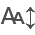

In [20]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from itables import show
import itables.options as opt

def InteractiveTable():
    # Configure itables options
    opt.maxBytes = 0  # No limit on data size
    opt.maxColumns = 0  # Display all columns

    # Display the .obs dataframe
    if "total_expression" in adata.var.columns:    
   
        highly_expressed = adata.var.sort_values(by="total_expression", ascending=False).head(20)
        show(highly_expressed)
    else:
        show(adata.var)

### Execute __main__.py

Folder 'plots' already exists.
Folder 'AnnData' already exists.
All required .gz files are already present in: C:\Users\kkomenda\Documents\scRNAseq\test\RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene\filtered
Filtered directories: ['C:\\Users\\kkomenda\\Documents\\scRNAseq\\test\\RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene\\filtered']
Processing directory: C:\Users\kkomenda\Documents\scRNAseq\test\RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene\filtered
Filter out cells expressing fewer than: 78.02 genes (1th percentile)
Filter out genes detected in fewer than: 90.75 cells (5th percentile)
Filtered data saved to RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene_filtered.h5ad
Prefix "mt-" found with 25 mitochondrial genes:
['mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Nd1', 'mt-Tq', 'mt-Tm', 'mt-Nd2', 'mt-Ta', 'mt-Tn', 'mt-Tc']
Annotated mitochondrial genes and calculated QC metrics.
Filtered cells based on gene counts with mt_analysis.


C:\Users\kkomenda\AppData\Local\anaconda3\envs\scrna\Lib\site-packages\scanpy\preprocessing\_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved HighlyExpressedGenes plot as RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene_HighlyExpressedGenes.png
Saved PCAplot plot as RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene_PCAplot.png
Saved ClusterPlot plot as RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene_ClusterPlot.png


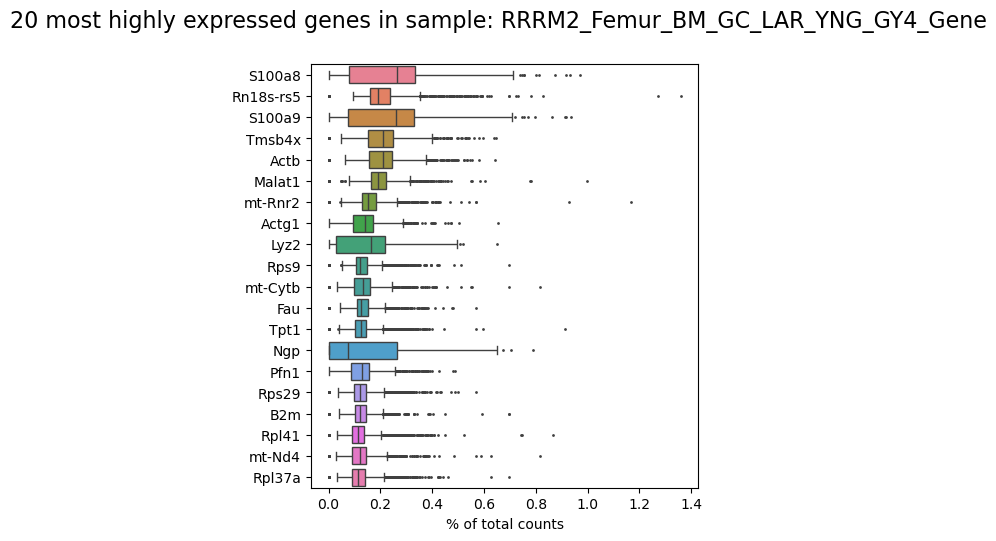

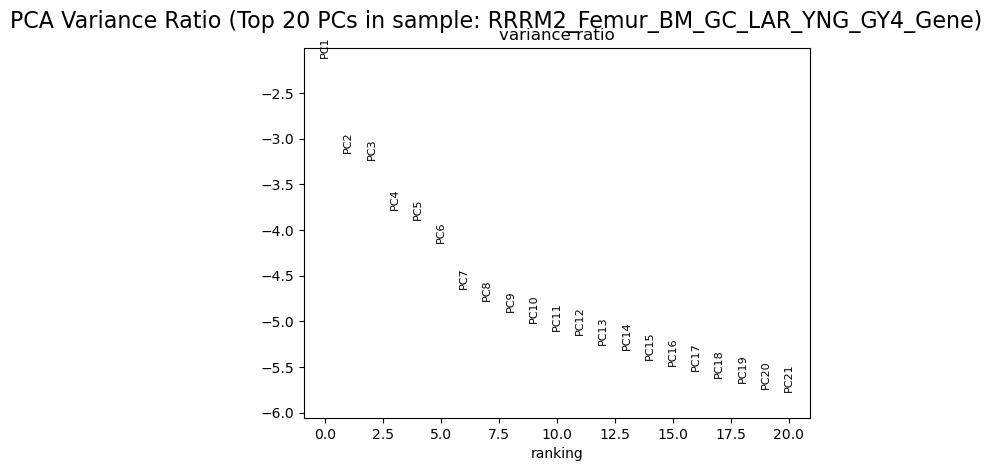

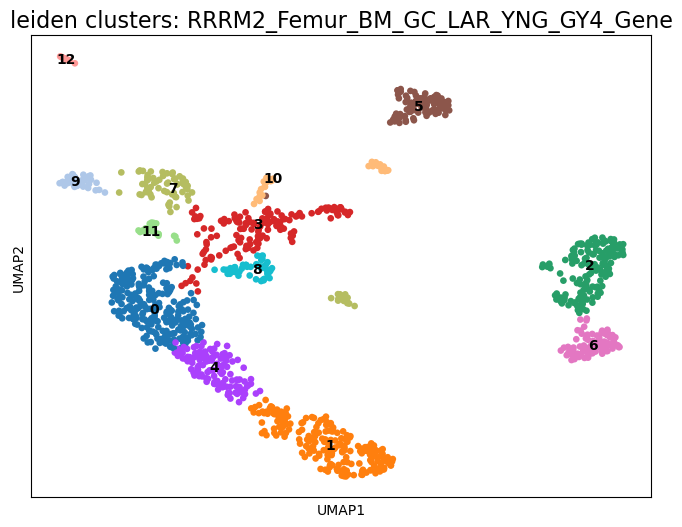

Finished processing RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene

Raw count matrix was saved to: count_matrix_RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene.csv
Metadata was saved to: metadata_RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene.csv


C:\Users\kkomenda\AppData\Local\Temp\1\ipykernel_22768\3468382249.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["sample_name"] = sample_name
C:\Users\kkomenda\AppData\Local\Temp\1\ipykernel_22768\3468382249.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["Tissue_type"] = Tissue_type
C:\Users\kkomenda\AppData\Local\Temp\1\ipykernel_22768\3468382249.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [58]:
import os
import scanpy as sc

'''This script uses a loop to find all subdirectories
of working directory that contain scRNAseq datasets.
'''

#change working directory to base_path:
os.chdir(base_path)

#generate output folder structure:
Structure()

#Module 1.5: Get Directories:
GetDirectories(base_path)

#STEP 4: Run Downstream analysis in a loop, until it process all data from "out" list:
for input_path in out:
    print(f"Processing directory: {input_path}")

    #STEP 4.1: Load AnnData as 10x_mtx:
    adata = sc.read_10x_mtx(input_path, var_names='gene_symbols', cache=True)

    #STEP 4.2: Define current sample name:
    #NOTE: sample name is retrieved from parent folder - it may crash when structure will be different
    sample_name = os.path.basename(os.path.dirname(input_path))

    #STEP 4.3: Define the results file based on sample name:
    results_file = f"{sample_name}_results_scoreCT.h5ad"

    # Module 4
    BasicFiltering(save_data=True)

    # Module 5
    #plotCellsAndGenes(save_data=True)

    # Module 6
    mtAnalysis()

    # Module 7
    #plotViolinScatter(save_data=True)

    # Module 8
    FilterCells()

    # Module 9
    Normalization(adata)
    RegressOut(adata)

    # Module 10
    plotPostNormalization(save_data=True)

    # Module 11
    plotPCA(save_data=True)

    # Module 12
    ClusterAnalysis()

    #Module 12.5 - plotCluster:
    ClusterPlot(save_data=True)

    #Module 2:  Load GeneMarkers:
    #GitLoad(marker_file)
    
    # Module 13
    #ScoreCTAnnotation(save_data=True)

    # Module 14
    #PlotUMAP("scoreCT", save_data=True)

    #Module 15:
    #InteractiveTable()
    print(f"Finished processing {sample_name}\n")

    #Save DGE data:
    ExtractDE(save_data=True)
    ExtractMetadata(save_data=True)


### Manually calculate highly expressed genes - do not use!
Technical purposes only

In [942]:
import numpy as np

# Compute the total expression for each gene
total_expression = np.array(adata.X.sum(axis=0)).flatten()

# Get the gene names
gene_names = adata.var_names

# Sort genes by total expression in descending order
sorted_indices = np.argsort(-total_expression)
top_genes = gene_names[sorted_indices]
top_counts = total_expression[sorted_indices]

# Display the top 10 genes
adata.var['total_expression'] = total_expression

In [960]:
import pandas as pd
import numpy as np
from scipy.sparse import issparse

# Compute the percentage of total counts per gene
if issparse(adata.X):  # Handle sparse matrix
    total_counts_per_gene = np.array(adata.X.sum(axis=0)).flatten()
    total_counts = adata.X.sum()
else:  # Dense matrix
    total_counts_per_gene = adata.X.sum(axis=0)
    total_counts = adata.X.sum()

# Calculate percentage of total counts per gene
percent_total_counts = (total_counts_per_gene / total_counts) * 100

# Save these values to adata.var
adata.var['percent_total_counts'] = percent_total_counts

### DGE analysis workflow:

#### retrieve count matrix table:

In [56]:
import scanpy as sc
import pandas as pd
import numpy as np

def ExtractDE(save_data=False):
    
    # Extract raw count matrix
    count_matrix = pd.DataFrame(
        adata.raw.X.toarray() if not isinstance(adata.raw.X, np.ndarray) else adata.raw.X,
        index=adata.obs_names,  # Cells as rows
        columns=adata.raw.var_names  # Genes as columns
    )

    count_matrix = count_matrix.T

    if save_data:
        # Save the count matrix to a CSV file
        SaveData(count_matrix=count_matrix)
        
        #count_matrix.to_csv(f"raw_count_matrix.csv")


In [57]:
ExtractDE(save_data=True)

Raw count matrix was saved to: count_matrix_RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene.csv


#### Retrieve metadata table:

In [59]:
import re
import scanpy as sc
import pandas as pd

def ExtractMetadata(save_data=False):
    # This data is not raw, because we want to catch annotated clusters for cells
    # Every cell is represented by a label from a barcode
    metadata = adata.obs[["leiden"]]

    # Add original sample_name column
    metadata["sample_name"] = sample_name

    # Split the sample_name using the '_' separator
    split_name = sample_name.split("_")

    # Initialize metadata fields
    Tissue_type = None
    Age = None
    Conditions = None

    # Process the split parts of the sample_name
    if "BM" in split_name:
        Tissue_type = "Bone_marrow"
    elif "PBMC" in split_name:
        Tissue_type = "PBMC"
    elif "SPL" in split_name:
        Tissue_type = "Spleen"
        
    if "YNG" in split_name:
        Age = "young"
    elif "OLD" in split_name:
        Age = "old"
    if "GC" in split_name:
        Conditions = "Ground_control"
    elif "FLT" in split_name:
        Conditions = "Flight"


    # Add the derived metadata to the DataFrame
    metadata["Tissue_type"] = Tissue_type
    metadata["Age"] = Age
    metadata["Conditions"] = Conditions

    # Save the metadata to a CSV file if requested
    if save_data:
        SaveData(metadata=metadata)

    return metadata

In [ ]:
ExtractMetadata(save_data=True)

#### check if datasets are sparse:

In [6]:
#It is important to select proper DGE tool for specific dataset.

#If dataset has more than 50% of zero elements it is considered as sparse

In [7]:
import pandas as pd
import numpy as np
data= pd.read_csv(r"C:\Users\kkomenda\Documents\scRNAseq\test\DGE_plots_test\count_matrix_RRRM2_Femur_BM_FLT_LAR_OLD_FO19_Gene.csv", index_col=0)
data2= pd.read_csv(r"C:\Users\kkomenda\Documents\scRNAseq\test\DGE_plots_test\count_matrix_RRRM2_Femur_BM_GC_LAR_OLD_GO19_Gene.csv", index_col=0)

In [5]:
total_elements = data.size
zero_elements = (data==0).sum().sum()
sparsity = zero_elements/total_elements

print(f"Sparsity of the dataset is: {sparsity: 0.2%}")

Sparsity of the dataset is:  91.57%


### Load adata - fix legend, further analysis:

#### load adata and display:

In [7]:
adata = sc.read(r"C:\Users\kkomenda\Documents\scRNAseq\test\AnnData\RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene_annotated.h5ad")

Saved UMAP plot as RRRM2_Femur_BM_GC_LAR_YNG_GY4_Gene_UMAP_scoreCT.png


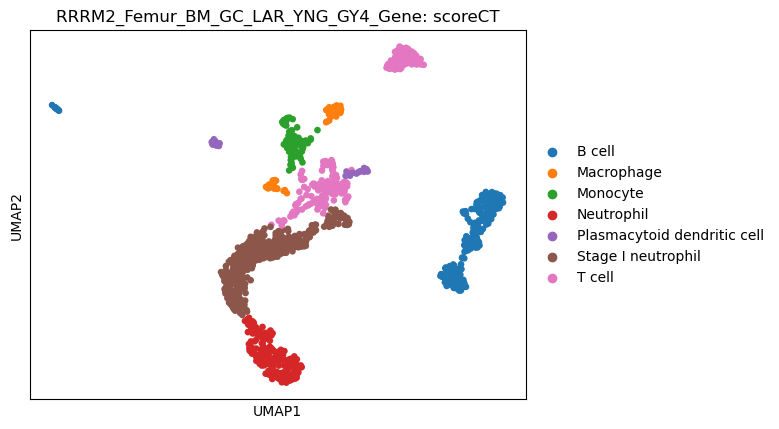

In [31]:
PlotUMAP("scoreCT", save_data=True)

#### Further visualizations:

In [26]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0        1       2       3       4         5       6       7      8  \
0    Ngp    Cxcr2    Ighm    Ptma    Mmp8    Ms4a4b  H2-Eb1    Ccr2  Hmgn2   
1   Camp    Csf3r  Vpreb3    Ppia    Mmp9  AW112010   H2-Aa    Psap  Hmgb2   
2    Ltf     Ccl6    Ebf1   Rpl41  Retnlg     Il2rb    Cd74  Ms4a6c  Chil3   
3   Lcn2  S100a11   Cd79b    Rpsa   Mmp25     H2-Q7  H2-Ab1  S100a4  H2az1   
4  Anxa1    Msrb1    Spib  Tuba1b   Cd177     Rplp1    Ighd    Npc2   Camp   

         9       10     11       12  
0     Cst3   Lgals1   Ctsb   Vpreb1  
1  Clec4a3    Plac8   Fth1    Igll1  
2     Apoe     Ptms   Psap     Dntt  
3     Ctss  Hsp90b1   Ftl1     Lef1  
4    Csf1r    Rps11  Vcam1  Tspan13

In [27]:
#Table with score and results:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n            0_p      1_n            1_p     2_n           2_p     3_n  \
0    Ngp  1.500268e-115    Cxcr2  2.052518e-100    Ighm  3.370763e-85    Ptma   
1   Camp  2.522320e-114    Csf3r   6.093612e-94  Vpreb3  4.127673e-82    Ppia   
2    Ltf  1.311449e-112     Ccl6   9.853200e-94    Ebf1  7.570769e-81   Rpl41   
3   Lcn2  3.057595e-112  S100a11   1.433445e-89   Cd79b  2.453861e-80    Rpsa   
4  Anxa1  2.763416e-106    Msrb1   4.008411e-88    Spib  7.755269e-78  Tuba1b   

            3_p     4_n           4_p  ...    8_n           8_p      9_n  \
0  4.415517e-29    Mmp8  4.100916e-68  ...  Hmgn2  2.708473e-25     Cst3   
1  4.670364e-21    Mmp9  5.581658e-59  ...  Hmgb2  8.354726e-25  Clec4a3   
2  3.956015e-18  Retnlg  3.996893e-48  ...  Chil3  5.012071e-22     Apoe   
3  1.484470e-17   Mmp25  2.605010e-40  ...  H2az1  7.494885e-21     Ctss   
4  1.685978e-16   Cd177  8.090490e-40  ...   Camp  1.476298e-20    Csf1r   

            9_p     10_n          10_p   11_n          11_p     12_n  \
0  9.149891e-26   Lgals1  2.566729e-20   Ctsb  2.756682e-16   Vpreb1   
1  5.153613e-25    Plac8  1.003307e-18   Fth1  5.165975e-14    Igll1   
2  4.336561e-24     Ptms  1.248213e-18   Psap  2.967142e-12     Dntt   
3  1.604759e-23  Hsp90b1  3.800885e-16   Ftl1  1.213766e-11     Lef1   
4  2.071854e-23    Rps11  1.921129e-15  Vcam1  4.094607e-11  Tspan13   

           12_p  
0  2.372959e-09  
1  2.487854e-09  
2  3.046745e-09  
3  3.284471e-09  
4  3.590283e-09  

[5 rows x 26 columns]

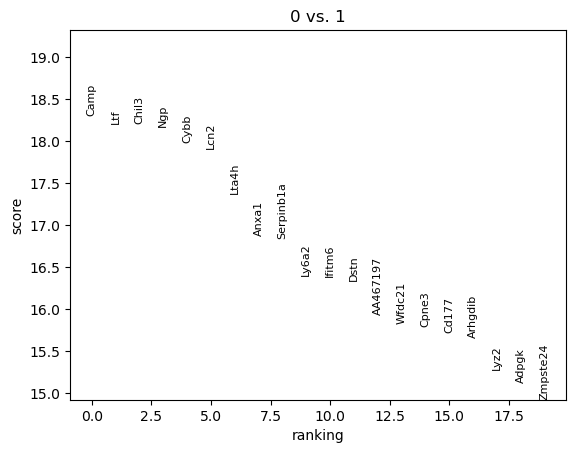

In [28]:
#Compare to single cluster:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

C:\Users\kkomenda\AppData\Local\anaconda3\envs\scrna\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


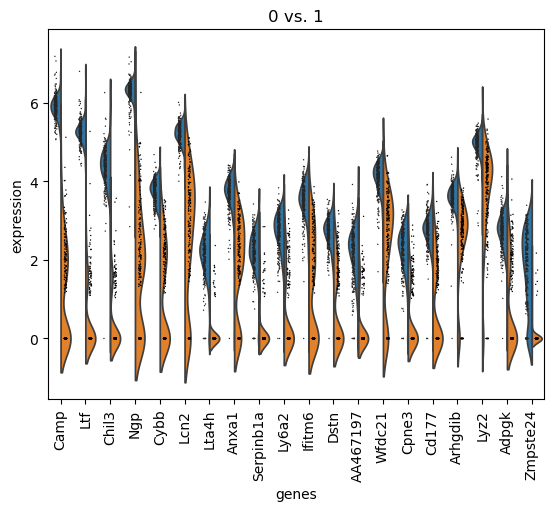

In [29]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=20)